In [ ]:
# GET POR Files Already Downloaded
import glob
import shutil
from FDIC import constants as paths

source = '/Users/kris/Downloads/FFIEC/'
#destination = '/Users/kris/Library/CloudStorage/OneDrive-Personal/Documents/Visual Studio 2019/Repos/ffiec-xbrl/PubData/Src/RSSDs/'
destination = paths.localPath + paths.folder_RSSDs

for src in glob.glob(source + '*/* POR *'):
    shutil.copy(src, destination)

In [1]:
# Imports and Constants
import pandas as pd
import numpy as np

from FDIC import ExEngine
from FDIC import constants as paths
from FDIC.ETL import ETL
from FDIC.RateLimiter import RateLimiter 
from FDIC.viewer import Viewer

#dtypes = {'RSSD_ID':str,
#          'FDIC_Certificate_Number':str,
#          'OCC_Charter_Number':str,
#          'OTS_Docket_Number':str,
#          'Primary_ABA_Routing_Number':str,
#          'Financial_Institution_Name': str,
#          'Financial_Institution_Address': str,
#          'Financial_Institution_City': str,
#          'Financial_Institution_State': str,
#          'Financial_Institution_Zip_Code': str,
#          'Financial_Institution_Filing_Type': str,
#          'Last Date/Time Submission Updated On': 'str'}

dtypes = {'IDRSSD': np.dtype('str'),
          'FDIC Certificate Number': np.dtype('str'),
          'OCC Charter Number': np.dtype('str'),
          'OTS Docket Number': np.dtype('str'),
          'Primary ABA Routing Number': np.dtype('str'),
          'Financial Institution Name': np.dtype('str'),
          'Financial Institution Address': np.dtype('str'),
          'Financial Institution City': np.dtype('str'),
          'Financial Institution State': np.dtype('str'),
          'Financial Institution Zip Code': np.dtype('str'),
          'Financial Institution Filing Type': np.dtype('str'),
          'Last Date/Time Submission Updated On': np.dtype('str')}

filepath_in = 'PubData/Src/RSSDs/'
filepath_out = 'PubData/'
filename = 'FFIEC CDR Call Bulk POR 03312024.txt'

In [ ]:
# Compare Bank_Dim and RSSD_Dict
df_bank = pd.read_csv(filepath_out + 'Bank_Dim.csv', sep=',', index_col=False, quotechar='"')
df_rssd = pd.read_csv(filepath_out + 'RSSD_Dict.csv', sep=',', index_col=False, quotechar='"')

print(df_bank.shape, df_rssd.shape)


In [ ]:
#Open File (Bank_dim from RSSD_Por)

#with open(filename, 'r') as file:
df = pd.read_csv(filepath_in + filename, sep='\t', index_col=False, quotechar='"', dtype = dtypes, parse_dates=['Last Date/Time Submission Updated On'])

In [ ]:
#Clean RSSD_Por File
df = df.apply(lambda x: x.str.strip() if x.dtype.name == 'object' else x, axis=0)

In [ ]:
#Clean RSSD_Por Format - Align with and Create RSSD_Dict.csv
df.rename(columns={'IDRSSD': 'RSSD_ID'}, inplace=True)
df.columns = df.columns.str.replace(' ', '_')

#Create RSSD_Dict file
#df.iloc[:25].to_csv(filepath_out + 'RSSD_Dict.csv', sep=',', quotechar='"', index= False,)
df.to_csv(filepath_out + 'RSSD_Dict.csv', sep=',', quotechar='"', index= False)

In [ ]:
#Confirm data
df[:5]

#df.Financial_Institution_Address
#df.iloc[0,6]

In [ ]:

rate_limiter = RateLimiter(max_calls=2450, period_in_seconds=3660) #~2.4k every 60min
etl = ETL(paths.WSDL_path, rate_limiter)

#ExEngine.FillMaster('504713')
#etl.GenBankDim()
etl.DownloadCallReports(['XBRL'])

#etl.GenBankMaster()
#etl.GenCallMaster()

In [ ]:
try:
    if etl:
        pass
except:
        rate_limiter = RateLimiter(max_calls=2450, period_in_seconds=3660) #~2.4k every 60min
        etl = ETL(paths.WSDL_path, rate_limiter)

#tot = etl.ParseXBRL(call_report_path)
etl.GenBankMaster()
#etl.GenCallMaster()

In [ ]:
try:
    if etl:
        pass
except:
        rate_limiter = RateLimiter(max_calls=2450, period_in_seconds=3660) #~2.4k every 60min
        etl = ETL(paths.WSDL_path, rate_limiter)

etl.GenCallMaster()

In [3]:
viewer = Viewer()

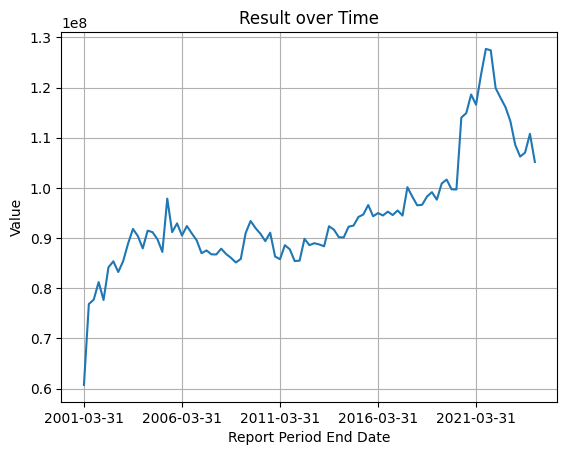

ReportPeriodEndDate
2001-03-31     60,743,000
2001-06-30     76,859,000
2001-09-30     77,755,000
2001-12-31     81,237,000
2002-03-31     77,668,000
                 ...     
2023-03-31    108,586,000
2023-06-30    106,247,000
2023-09-30    107,041,000
2023-12-31    110,792,000
2024-03-31    105,175,000
Name: Value, Length: 93, dtype: object

In [5]:
#Query for 1 institution, 1 item, and get aggregate results
viewer.query(MDRMitem='RCON2170', RSSDid=267652, calc='aggregate', chart=True)

In [ ]:
# Run 
viewer.query(MDRMitem='RCON2170', calc='aggregate', chart=True)

--Start of Dataframe Sandbox--

In [ ]:
## Create DF from Mastercall
path = paths.localPath + paths.filename_MasterCall
df = etl.loadCSV(path)

In [ ]:
## Create DF from ALL Bankcalls
path = '/Users/kris/data_sources/fdic/BulkReports/'
df = etl.createDF_from_CSV(path_root =path)
df

In [ ]:
df[:25]

In [ ]:
#Number of RSSD's by Period, by RSSD_ID, by MDRM_Item
g_df = df[df['RSSD_ID']==28013].groupby(['MDRM_Item', 'RSSD_ID', 'ReportPeriodEndDate'])['MDRM_Item'].count()
g_df

In [ ]:
#Field count by date (RSSD report count)
pvt = df[['MDRM_Item', 'ReportPeriodEndDate']].pivot_table(
    index=['MDRM_Item'],
    columns=['ReportPeriodEndDate'],
    values=['MDRM_Item'],
    aggfunc={'MDRM_Item': ['count']}
)
pvt.fillna(0, inplace=True)
pvt

#Filter out either rows or columns with only no reporting (only zeros)
#filtered_pvt = pvt.loc[(pvt > 0).any(axis=1),:]
filtered_pvt = pvt.loc[:, (pvt > 0).any(axis=0)]
filtered_pvt

In [ ]:
#Number of filers (RSSD's) by date
pvt = df[['ReportPeriodEndDate', 'RSSD_ID']].drop_duplicates().reset_index().pivot_table(
    index=['ReportPeriodEndDate'],
    values=['RSSD_ID'],
    aggfunc={'RSSD_ID': ['count']}
).sort_values(by='ReportPeriodEndDate', ascending=False)

pvt = pvt.set_axis([col for col in pvt.keys()], axis=1)
#pvt.reset_index(inplace=True)

pvt.fillna(0, inplace=True)
pvt

In [ ]:
filepath = 'PubData/MDRM_Dict.csv'
mdrm = etl.loadCSV(path = filepath)
mdrm

In [ ]:
mdrm[mdrm['Item_Name'].str.contains('TOTAL ASSETS')]
mdrm[mdrm['Item_Name'] == 'TOTAL ASSETS ']
#mdrm.iloc[1196]

In [ ]:
df[df['MDRM_Item']=='RCON2170']

In [ ]:
##Find rows that don't have INT values in Value column
df.dtypes

invalid_rows = df[df['Value'].apply(lambda x: isinstance(x, str) and not x.replace('.', '', 1).isdigit())]
invalid_rows

In [ ]:
##Format dtypes of dataframe
df = df.astype({
    'ReportPeriodEndDate': 'datetime64[ns]',
    'Item_Name': 'str',
    'MDRM_Item': 'str',
    'Confidential': 'bool'
    #'Value': 'float'
    })

In [ ]:
## Print analytics from dataframe

#Filter df by Item and Confidential status
#filtered_df = df[(df['MDRM_Item']=='RCON2170') & (df['Confidential']=='No')].astype({'Value': int})
filtered_df = df[(df['MDRM_Item']=='RCON2170')].astype({'Value': int})

totals = filtered_df.groupby(by='ReportPeriodEndDate')['Value'].sum().astype(int)
totals

counts = filtered_df.groupby(by='ReportPeriodEndDate')['Value'].count().astype(int)
counts

pctChgs = totals.pct_change()
pctChgs

res = pd.DataFrame({'Values':totals, 'pctChgs':pctChgs, 'Counts':counts})
res.index = res.index.strftime('%Y-%m-%d')
res.style.format({
    'Values': '{:,}',
    'pctChgs': lambda x: '{:.2%}'.format(x) if pd.notna(x) else x,
    'Counts': '{:,}'
})


In [ ]:
from matplotlib import pyplot as plt

# Plotting
fig, ax1 = plt.subplots()

# Plot summed values
color = 'tab:blue'
ax1.set_xlabel('ReportPeriodEndDate')
ax1.set_ylabel('Summed Values', color=color)
ax1.plot(res.index, res['Values'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for percentage change
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Percentage Change', color=color)
ax2.plot(res.index, res['pctChgs'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Format the x-axis dates
#fig.autofmt_xdate()

# Set x-axis major ticks to show at regular intervals
interval = 4
ax1.set_xticks(res.index[::interval])

# Rotate the x-axis labels for better readability
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Add a title
plt.title('Total Assets and YoY Chg')

# Show the plot
plt.show()



In [ ]:
#filtered_df = df[(df['ReportPeriodEndDate']=='2001-03-31') & (df['MDRM_Item']=='RCON2170')]
filtered_df = df[(df['RSSD_ID']=='140362') & (df['MDRM_Item']=='RCON2170') & (df['Confidential']==False)]
filtered_df